# COCO implementation test

This notebook is an implementation of the constrained covariance from [Kernel Constrained Covariance for Dependence Measurement, A.Gretton et al.,2005](https://proceedings.mlr.press/r5/gretton05a/gretton05a.pdf)

### Generating some random variables

In [1]:
import numpy as np

In [36]:
def X(n:int=None,cov: np.array=np.identity(3),mean: np.array = np.zeros(3))->np.array:
    """Args:
    n,int: number of samples by default n=None ie a single sample
    cov,np.array: covariance matrix by default cov=np.identity(3)
    mean: mean value vector by default mean=np.zeros(3)

    returns n samples of the 
    """
    return np.random.multivariate_normal(mean,cov,n)

In [38]:
print(X())

[-1.35713527 -0.82083418 -0.30300738]


### Implementing COCO

We know from (2.3) in the article that: $$COCO_{emp}(z,F,G)=\frac{1}{n}\sqrt{{\lVert \bar{K}^j\bar{K}^g \rVert}_2}$$

With $\bar{K}^f$ the matrix obtained via the projection $ \bar{K}^f  =  PK^fP$ with the projection operator $ P_{ij} = {\delta}_{ij}  - \frac{1}{n}$ and Gram matrix ${K^{f}}_{ij} =k_f(x_i,x_j)$. $\; \bar{K}^g$ is defined analogously.

In [70]:
def map_projection_op(i:int,j:int,n:int)-> float:
    """This function gives the value of Projector operator matrix coefficients
    Args:
        i : line number
        j : row number
        n : number of samples
    Returns:
        P_ij
    """
    if i==j:
        return 1-1/n
    else:
        return -1/n 
    
def map_kernel_gram(i:int,j:int,x:np.array,k:callable) -> float:
    """This function gives the value of the Gram matrix coefficients
    
    Args:
        i : line number
        j : row number
        x : samples vector
        k : kernel
    Returns:
        K_ij
    """
    return k(x[i],x[j])


def COCO(Kf:callable,Kg:callable,x:np.array,y:np.array)->float:
    """This function computes the constrained covariance for two kernels and some samples
    
    Args:
        Kf : first kernel
        Kg : second kernel
        x : samples from F
        y : samples from G
    Returns:
        COCO_emp
    """
    n= len(x)
    Kf_gram = np.array([list( map_kernel_gram(i,j,x,Kf) for i in range(n)) for j in range(n)])
    Kg_gram = np.array([list( map_kernel_gram(i,j,y,Kg) for i in range(n)) for j in range(n)])
    P = np.array([list( map_projection_op(i,j,n) for i in range(n)) for j in range(n)])
    Kf_bar = np.matmul(P,np.matmul(Kf_gram,P))
    Kg_bar = np.matmul(P,np.matmul(Kg_gram,P))

    return np.sqrt(np.linalg.norm(np.matmul(Kf_bar,Kg_bar),2))/n
    

### Test on some Kernels
Here we define some kernels and perform some test using COCO on samples from the variables previously defined

In [68]:

def K_laplacian(x:np.array,y:np.array)->float:
    """This function returns the evaluation of the laplacian kernel on x and y
    Args:
        x : random variable vector
        y : random variable vector
    Returns:
        k(x,y)
        
    """
    factor = 1
    return np.exp(-factor*np.linalg.norm(x-y,1))

def K_gaussian(x:np.array,y:np.array)->float:
    """This function returns the evaluation of the gaussian kernel on x and y
    
    Args:
        x : random variable vector
        y : random variable vector
    Returns:
        k(x,y)
    """
    factor = 1
    return np.exp(-factor*np.linalg.norm(x-y,2))
    


In [71]:
Kf = K_gaussian
Kg = K_gaussian
x = X(10)
y = X(10)
COCO(Kf,Kg,x,y)

0.113576960097133

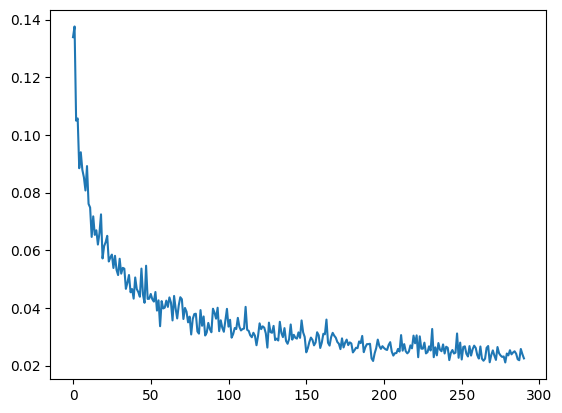

In [82]:
import matplotlib.pyplot as plt

res = np.empty(491)
for i in range(10,501):
    x = X(i)
    y = X(i)
    res[i-10] = COCO(Kf,Kg,x,y)

plt.plot(res)
plt.show()
